In [1]:
import numpy as np
import pandas as pd
from os import listdir
from os.path import join, isfile

# info tables
infotable = f'/data01/homes/dipiano/E4/irf_random/crab/sim/merged_simulator_data.dat'

# dataset 
mapsname = '/data01/homes/dipiano/E4/irf_random/crab/regressor_100s_5sgm_5000sz_200x200_YESnorm_NOstretch.npy'
ds = np.load(mapsname, allow_pickle=True, encoding='latin1', fix_imports=True).flat[0]
print(f"Maps: {ds.keys()}")
print(f"DS dataset size: {len(ds['DS'])}")

Maps: dict_keys(['DS', 'LABELS', 'SEED', 'SOURCE', 'FILE', 'EXPOSURE'])
DS dataset size: 5000


In [3]:
from astroai.tools.utils import split_regression_dataset

train_data, train_labels, test_data, test_labels = split_regression_dataset(ds, split=80, reshape=True, binning=200)

print(f"Train dataset: {len(train_data)}, {train_data.shape}")
print(f"Train labels: {len(train_labels)}, {train_labels.shape}")
print(f"\nTest dataset: {len(test_data)}, {test_data.shape}")
print(f"Test labels: {len(test_labels)}, {test_labels.shape}")

(4000, 200, 200) (4000, 2)
Train dataset: 4000, (4000, 200, 200, 1)
Train labels: 4000, (4000, 2)

Test dataset: 1000, (1000, 200, 200, 1)
Test labels: 1000, (1000, 2)


In [4]:
import matplotlib.pyplot as plt
import astropy.units as u

def plot_heatmap_wcs(heatmap, transform='world', title='heatmap', xlabel='x', ylabel='y', 
                     show=False, save=False, save_name=None, wcs=None, src=None):
    if wcs is not None:
        ax = plt.subplot(projection=wcs)
        ax.coords[0].set_format_unit(u.deg)
        ax.coords[1].set_format_unit(u.deg)
        ax.invert_xaxis()
    else:
        ax = plt.subplot()
        
    img = ax.imshow(heatmap, vmin=0, vmax=1, origin='lower')
    #ax.scatter(src.ra.deg, src.dec.deg, marker='o', s=50, facecolor='none', edgecolor='k',
    #           transform=ax.get_transform('world'))
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.colorbar(img)
    if save and save_name is not None:
        plt.savefig(save_name)
    if show:
        plt.show()
    plt.close()
    return

In [12]:
from astroai.tools.utils import plot_heatmap, set_wcs
from astropy.coordinates import SkyCoord

# get random seed
#idx = np.random.choice(range(len(train_seeds)))

idx = 3531
seed = 3532  ## QUI QUALCOSA NON VA NELLA CONVERSIONE DEL LABEL!!! HO SOLO 250 PIXELS PER LATO!!!!
print(f"IDX={idx} --> SEED={seed}")
binning = 250
with_wcs = True

# get simulation data
infodata = pd.read_csv(infotable, sep=' ', header=0).sort_values(by=['seed'])
row = infodata[infodata['seed']==seed]
row

IDX=3531 --> SEED=3532


,name,seed,start,stop,duration,source_ra,source_dec,point_ra,point_dec,offset,irf,fov,sim_time
63531,crab_03532,3532,0,100,100,332.953012,59.696286,336.062743,59.921357,1.579804,North_z20_5h_LST,2.5,7.874264


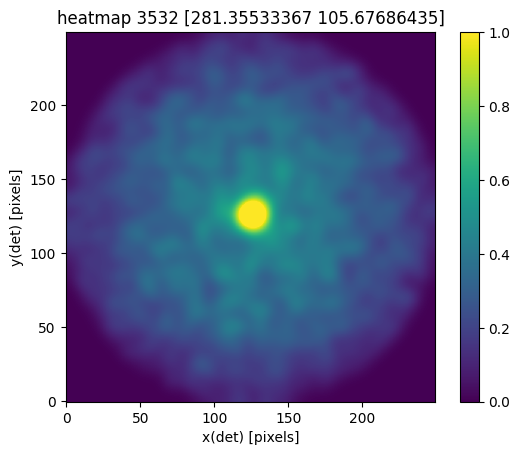

In [13]:
# create wcs
if with_wcs:
    w = set_wcs(point_ra=row['point_ra'].values[0], point_dec=row['point_dec'].values[0], 
                point_ref=binning/2+0.5, pixelsize=(2*row['fov'].values[0])/binning)
    src = SkyCoord(ra=row['source_ra'].values[0], dec=row['source_dec'].values[0], unit='deg')
else:
    w = None
    src = train_labels[idx]

# plot map
plot_heatmap_wcs(ds['DS'][seed], title=f"heatmap {seed} {ds['LABELS'][idx]}", src=src,
                 xlabel='x(det) [pixels]', ylabel='y(det) [pixels]',
                 show=True, save=False, save_name=None)


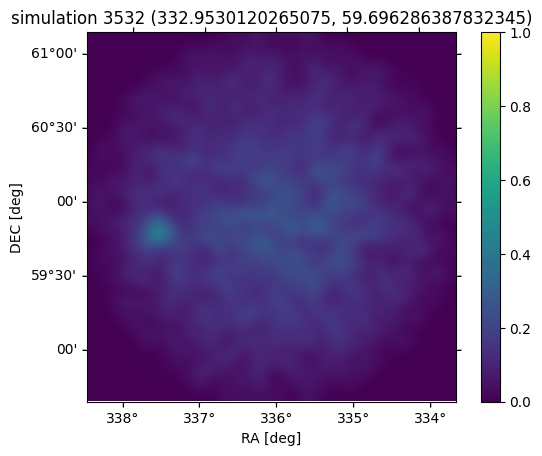

In [14]:
from astropy.table import Table
from astroai.tools.utils import extract_heatmap_from_table

img = f"/data01/homes/dipiano/E4/irf_random/crab/sim/{row['name'].values[0]}.fits"

heatmap = Table.read(img, hdu=1).to_pandas()
heatmap = extract_heatmap_from_table(heatmap, smoothing=5, nbins=250)

plot_heatmap_wcs(heatmap, title=f"simulation {seed} {(row['source_ra'].values[0], row['source_dec'].values[0])}", 
                 wcs=w, src=src, xlabel='RA [deg]', ylabel='DEC [deg]',
                 show=True, save=False, save_name=None, transform='world')

### Check WCS to pixel conversion

In [15]:
from astroai.tools.utils import *

w = set_wcs(point_ra=row['point_ra'].values[0], point_dec=row['point_dec'].values[0], 
                point_ref=binning/2+0.5, pixelsize=(2*row['fov'].values[0])/binning)
x, y = w.world_to_pixel(SkyCoord(row['source_ra'].values[0], row['source_dec'].values[0], unit='deg'))
x, y

(array(281.35533367), array(105.67686435))

In [16]:
sky = w.pixel_to_world(x, y)
sky

<SkyCoord (ICRS): (ra, dec) in deg
    (332.95301203, 59.69628639)>